# 🧠 Deep Reinforcement Learning — Doom Agent (SS2025)

Welcome to the last assignment for the **Deep Reinforcement Learning** course (SS2025). In this notebook, you'll implement and train a reinforcement learning agent to play **Doom**.

You will:
- Set up a custom VizDoom environment with shaped rewards
- Train an agent using an approach of your choice
- Track reward components across episodes
- Evaluate the best model
- Visualize performance with replays and GIFs
- Export the trained agent to ONNX to submit to the evaluation server

In [2]:
# # Clone repo
!git clone https://$token@github.com/gerkone/jku.wad.git
%cd jku.wad

Cloning into 'jku.wad'...
remote: Enumerating objects: 191, done.
remote: Counting objects: 100% (191/191), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 191 (delta 110), reused 171 (delta 97), pack-reused 0 (from 0)
Receiving objects: 100% (191/191), 958.82 KiB | 7.16 MiB/s, done.
Resolving deltas: 100% (110/110), done.
/content/jku.wad


In [3]:
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126 # when run locally

In [ ]:
# Install the dependencies
!pip install torch
!pip install numpy matplotlib vizdoom portpicker gym onnx tqdm
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 110.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvji

In [ ]:
from typing import Dict, Sequence, Tuple

import torch
from collections import deque, OrderedDict
import collections
from copy import deepcopy
import random
import numpy as np
import torch.nn.functional as F
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
import onnx
import json
from tqdm.auto import trange

from gym import Env
from torch import nn
from einops import rearrange

import sys
sys.path.insert(0, "./")

from doom_arena import VizdoomMPEnv
from doom_arena.reward import VizDoomReward
from doom_arena.render import render_episode
from IPython.display import HTML
from vizdoom import ScreenFormat

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import os
drive_models_dir = "/content/drive/My Drive/DoomAgentModels_JKUWAD"
if not os.path.exists(drive_models_dir):
    os.makedirs(drive_models_dir)
    print(f"Created directory: {drive_models_dir}")
else:
    print(f"Directory already exists: {drive_models_dir}")


Directory already exists: /content/drive/My Drive/DoomAgentModels_JKUWAD


## Environment configuration

ViZDoom supports multiple visual buffers that can be used as input for training agents. Each buffer provides different information about the game environment, as seen from left to right:


Screen
- The default first-person RGB view seen by the agent.

Labels
- A semantic map where each pixel is tagged with an object ID (e.g., enemy, item, wall).

Depth
- A grayscale map showing the distance from the agent to surfaces in the scene.

Automap
- A top-down schematic view of the map, useful for global navigation tasks.

![buffers gif](https://vizdoom.farama.org/_images/vizdoom-demo.gif)

In [ ]:
USE_GRAYSCALE = True

PLAYER_CONFIG = {
    "n_stack_frames": 1,
    "extra_state": ["depth"],
    "hud": "none",
    "crosshair": True,
    "screen_format": "ScreenFormat.GRAY8" if USE_GRAYSCALE else "ScreenFormat.CRCGCB"
}

In [ ]:
# environment training paramters
NUM_BOTS = 4
EPISODE_TIMEOUT = 2100
OBS_SHAPE      = (
    (1 if USE_GRAYSCALE else 3 + (1 if "depth" in PLAYER_CONFIG["extra_state"] else 0)) * PLAYER_CONFIG["n_stack_frames"],
    120, 90
)

# model hyperparams
GAMMA = 0.999
EPISODES = 800
BATCH_SIZE = 32
REPLAY_BUFFER_SIZE = 20_000
MIN_BUFFER_FILL = 1000
LEARNING_RATE = 1e-4
EPSILON_START = 1.0
EPSILON_END = 0.1
EPSILON_DECAY_STEP = 0.99997

# N-Step returns
N_STEP_RETURN = 3

# PER hyperparams
PER_ALPHA = 0.6 # prioritization exponent
PER_BETA_START = 0.4 # initial IS weight exponent
PER_BETA_FRAMES = EPISODES * (EPISODE_TIMEOUT // 2) # anneal beta over approx this many steps

# Training frequency
TRAIN_EVERY_N_STEPS = 4 # perform training step every 4 environment steps
N_UPDATES_PER_TRAIN_STEP = 1 # number of batch updates when training is triggered

## Reward function
In this task, you will define a reward function to guide the agent's learning. The function is called at every step and receives the current and previous game variables (e.g., number of frags, hits taken, health).

Your goal is to combine these into a meaningful reward, encouraging desirable behavior, such as:

- Rewarding frags (enemy kills)

- Rewarding accuracy (hitting enemies)

- Penalizing damage taken

- (Optional) Encouraging survival, ammo efficiency, etc.

You can return multiple reward components, which are summed during training. Consider the class below as a great starting point!

In [ ]:
# ---------------------------------------------------------------
# 🥇 reward function
# ---------------------------------------------------------------

class YourReward(VizDoomReward):
    def __init__(self, num_players: int):
        # Parameters for movement bonus
        self.movement_bonus_window = 35 * 2 # approx 2 seconds at 35 FPS (70 steps)
        self.movement_reward_multiplier_hit = 1.0  # Bonus = 1.0 * base_hit_reward (doubling hit reward if preceded by movement)
        self.movement_reward_multiplier_frag = 0.2 # Bonus = 0.2 * base_frag_reward (extra +20 for a frag after moving)
        self.min_movement_threshold = 1.0 # min change in X or Y to be considered "significant movement"

        # State for tracking movement
        self.player_pos_history = {}

        super().__init__(num_players)

    def reset(self):
        super().reset()
        # Reset state for productive movement bonus
        self.player_pos_history[0] = {
            "last_significant_move_step": -self.movement_bonus_window -1, # no bonus at episode start
            "last_pos_x": None,
            "last_pos_y": None
        }


    def __call__(
        self,
        vizdoom_reward: float,
        game_var: Dict[str, float],
        game_var_old: Dict[str, float],
        player_id: int,
    ) -> Tuple[float, float, float, float, float]:

        self._step += 1

        # Base rewards
        current_frags = game_var.get("FRAGCOUNT", 0.0)
        old_frags = game_var_old.get("FRAGCOUNT", 0.0)
        r_frag = 100.0 * (current_frags - old_frags)

        current_hits = game_var.get("HITCOUNT", 0.0)
        old_hits = game_var_old.get("HITCOUNT", 0.0)
        r_hit_base = 2.0 * (current_hits - old_hits)

        current_hits_taken = game_var.get("HITS_TAKEN", 0.0)
        old_hits_taken = game_var_old.get("HITS_TAKEN", 0.0)
        r_damaged = -0.1 * (current_hits_taken - old_hits_taken)

        # Movement bonus: after movement hits are rewarded additionally
        # encourages movement, discourages passivity and blind and constant shooting
        r_movement_bonus = 0.0
        player_state = self.player_pos_history.get(player_id)
        if player_state is None: # initialize
            player_state = {
                "last_significant_move_step": -self.movement_bonus_window -1,
                "last_pos_x": game_var.get("POSITION_X"),
                "last_pos_y": game_var.get("POSITION_Y")
            }
            self.player_pos_history[player_id] = player_state

        # Get positions
        current_pos_x = game_var.get("POSITION_X")
        current_pos_y = game_var.get("POSITION_Y")

        # Calculate position deltas
        if player_state["last_pos_x"] is not None and current_pos_x is not None:
            delta_pos_x = abs(current_pos_x - player_state["last_pos_x"])
            delta_pos_y = abs(current_pos_y - player_state["last_pos_y"])

            # Check if movement is significant
            if delta_pos_x > self.min_movement_threshold or \
               delta_pos_y > self.min_movement_threshold:
                player_state["last_significant_move_step"] = self._step

        # Update last known position for next step
        player_state["last_pos_x"] = current_pos_x
        player_state["last_pos_y"] = current_pos_y

        # Check if a hit or frag occurred and if it was within the bonus window
        recently_moved = (self._step - player_state["last_significant_move_step"] <= self.movement_bonus_window)

        if recently_moved:
            if r_hit_base > 0:
                r_movement_bonus += r_hit_base * self.movement_reward_multiplier_hit
                # todo: mechanism to consume the bonus
            if r_frag > 0:
                r_movement_bonus += r_frag * self.movement_reward_multiplier_frag

        # Small cost for living to encourage engagement
        r_cost_of_living = -0.005

        return r_frag, r_hit_base, r_damaged, r_movement_bonus, r_cost_of_living

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [12]:
DTYPE = torch.float32

reward_fn = YourReward(num_players=1)

env = VizdoomMPEnv(
    num_players=1,
    num_bots=NUM_BOTS,
    bot_skill=0,
    doom_map="ROOM",  # NOTE simple, small map; other options: TRNM, TRNMBIG
    extra_state=PLAYER_CONFIG["extra_state"], # see info about states at the beginning of 'Environment configuration' above
    episode_timeout=EPISODE_TIMEOUT,
    n_stack_frames=PLAYER_CONFIG["n_stack_frames"],
    crosshair=PLAYER_CONFIG["crosshair"],
    hud=PLAYER_CONFIG["hud"],
    reward_fn=reward_fn,
)

Host 44697
Player 44697


## Agent

Implement **your own agent** in the code cell that follows.

* In `agents/dqn.py` and `agents/ppo.py` you’ll find very small **skeletons**—they compile but are meant only as reference or quick tests.  
  Feel free to open them, borrow ideas, extend them, or ignore them entirely.
* The notebook does **not** import those files automatically; whatever class you define in the next cell is the one that will be trained.
* You may keep the DQN interface, switch to PPO, or try something else.
* Tweak any hyper-parameters (`PLAYER_CONFIG`, ε-schedule, optimiser, etc.) and document what you tried.


In [ ]:
# Sample one observation to get real shape
reset_res = env.reset()
obs_list  = reset_res[0] if isinstance(reset_res, tuple) else reset_res
sample_obs = obs_list[0]
C, H, W = sample_obs.shape
print(f"Sample obs shape: C={C}, H={H}, W={W}")
ACTION_SPACE = env.action_space.n

# Define the network using that shape
class DuelingDQN(nn.Module):
    def __init__(self, in_channels, height, width, num_actions, hidden_dim=512):
        super().__init__()
        # encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=8, stride=4), nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),          nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),          nn.ReLU(),
            nn.Flatten()
        )
        # compute flattened size on real dims
        with torch.no_grad():
            dummy = torch.zeros(1, in_channels, height, width)
            conv_out_size = self.encoder(dummy).shape[1]
        print(f"Computed conv_out_size = {conv_out_size}")
        # streams
        self.value_stream = nn.Sequential(
            nn.Linear(conv_out_size, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        self.adv_stream   = nn.Sequential(
            nn.Linear(conv_out_size, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, num_actions)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.to(torch.float32) / 255.0
        feats = self.encoder(x)
        V = self.value_stream(feats)
        A = self.adv_stream(feats)
        return V + A - A.mean(dim=1, keepdim=True)

# Instantiate with true shape
num_actions = env.action_space.n
model     = DuelingDQN(C, H, W, ACTION_SPACE).to(device)
model_tgt = deepcopy(model).to(device)
model_tgt.eval()

# optimizer, scheduler
optimizer     = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler     = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=GAMMA)

Sample obs shape: C=4, H=128, W=128
Computed conv_out_size = 9216


In [14]:
# Prioritized Experience Replay and N-Step Buffer
class SumTree:
    def __init__(self, capacity: int):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1)
        self.data_pointer = 0

    def add(self, priority: float, data_idx: int):
        tree_idx = self.data_pointer + self.capacity - 1
        self.update(tree_idx, priority)
        self.data_pointer = (self.data_pointer + 1) % self.capacity

    def update(self, tree_idx: int, priority: float):
        change = priority - self.tree[tree_idx]
        self.tree[tree_idx] = priority
        while tree_idx != 0:
            tree_idx = (tree_idx - 1) // 2
            self.tree[tree_idx] += change

    def get_leaf(self, v: float) -> Tuple[int, float, int]:
        parent_idx = 0
        while True:
            cl_idx = 2 * parent_idx + 1
            cr_idx = cl_idx + 1
            if cl_idx >= len(self.tree):
                leaf_idx = parent_idx
                break
            else:
                if v <= self.tree[cl_idx]:
                    parent_idx = cl_idx
                else:
                    v -= self.tree[cl_idx]
                    parent_idx = cr_idx
        data_idx = leaf_idx - self.capacity + 1
        return leaf_idx, self.tree[leaf_idx], data_idx

    @property
    def total_p(self) -> float:
        return self.tree[0]

class PERBuffer:
    def __init__(self, capacity: int, alpha: float, beta_start: float, beta_frames: int):
        self.sum_tree = SumTree(capacity)
        self.capacity = capacity
        self.data = [None] * capacity # Stores (s, a, n_r, s', d, actual_n)
        self.data_idx_counter = 0 # To map sum_tree data_idx to self.data index
        self.alpha = alpha
        self.beta_start = beta_start
        self.beta = beta_start
        self.beta_increment = (1.0 - beta_start) / beta_frames
        self.epsilon_p = 0.01  # Small constant to ensure non-zero priority
        self.max_priority = 1.0 # Initial max priority

    def add(self, experience: Tuple):
        priority = self.max_priority # Add new experience with max priority
        self.data[self.data_idx_counter] = experience
        self.sum_tree.add(priority, self.data_idx_counter) # Pass data_idx_counter
        self.data_idx_counter = (self.data_idx_counter + 1) % self.capacity

    def sample(self, batch_size: int) -> Tuple[list, np.ndarray, np.ndarray]:
        batch_experiences = []
        idxs = np.empty((batch_size,), dtype=np.int32)
        is_weights = np.empty((batch_size,), dtype=np.float32)

        total_p = self.sum_tree.total_p
        segment = total_p / batch_size

        self.beta = min(1.0, self.beta + self.beta_increment)

        for i in range(batch_size):
            a = segment * i
            b = segment * (i + 1)
            s = random.uniform(a, b)

            tree_idx, p, data_idx = self.sum_tree.get_leaf(s)

            batch_experiences.append(self.data[data_idx])
            idxs[i] = tree_idx
            sampling_probabilities = p / total_p
            is_weights[i] = np.power(self.capacity * sampling_probabilities, -self.beta)

        is_weights /= is_weights.max() # normalization for stability
        return batch_experiences, idxs, is_weights

    def update_priorities(self, tree_indices: np.ndarray, abs_td_errors: np.ndarray):
        priorities = np.power(abs_td_errors + self.epsilon_p, self.alpha)
        for idx, p in zip(tree_indices, priorities):
            self.sum_tree.update(idx, p)
            self.max_priority = max(self.max_priority, p)

    def __len__(self) -> int:
        return self.sum_tree.data_pointer if self.sum_tree.tree[0] < 1e-5 else self.capacity



In [15]:
replay_buffer = PERBuffer(REPLAY_BUFFER_SIZE, PER_ALPHA, PER_BETA_START, PER_BETA_FRAMES)
epsilon = EPSILON_START

In [ ]:
# EMA update
@torch.no_grad()
def update_ema(ema_model, src_model, decay: float = 0.999):
    for (p_e, p_s) in zip(ema_model.parameters(), src_model.parameters()):
        p_e.data.mul_(decay).add_(p_s.data, alpha=1 - decay)

# Epsilon-greedy policy
@torch.no_grad()
def epsilon_greedy(obs: torch.Tensor, model_to_use: nn.Module, current_epsilon: float) -> int:
    if random.random() < current_epsilon:
        return env.action_space.sample()
    obs_t = obs.to(device, dtype=DTYPE).unsqueeze(0)
    return model_to_use(obs_t).argmax(dim=1).item()

# Logging lists
episode_returns_log = []
metrics_log = []
q_loss_log = []

### Validating Reward Function

In [30]:
# Test reward function

if 'VizDoomReward' not in globals(): # minimal dummy
    class VizDoomReward:
        def __init__(self, num_players): self._step = 0; self.num_players = num_players
        def reset(self): self._step = 0

reward_calculator = YourReward(num_players=1)
reward_calculator.reset()

# initial game variables
game_vars_t0 = {
    "FRAGCOUNT": 0.0, "HITCOUNT": 0.0, "HITS_TAKEN": 0.0,
    "POSITION_X": 100.0, "POSITION_Y": 100.0, "HEALTH": 100.0
}

col =-0.005 # cost of living

print("\nStep 1: No action, no movement, just cost of living")
game_vars_t1 = game_vars_t0.copy() # No change in game state vars
r_f, r_h, r_d, r_mv, r_cost = reward_calculator(0.0, game_vars_t1, game_vars_t0, 0)
total_r1 = r_f + r_h + r_d + r_mv + r_cost
print(f"Rewards: Frag={r_f}, HitBase={r_h}, Dmg={r_d}, MoveBonus={r_mv}, Cost={r_cost} -> Total={total_r1}")
print(f"Expected: Cost={col}, Others=0. Total={col}")
assert np.isclose(r_cost, col), "Cost of living incorrect"
assert np.isclose(total_r1, col), "Total reward step 1 incorrect"

print("\nStep 2: Significant Movement, no hits/frags")
game_vars_t2 = game_vars_t1.copy()
game_vars_t2["POSITION_X"] = 110.0 # moved significantly
r_f, r_h, r_d, r_mv, r_cost = reward_calculator(0.0, game_vars_t2, game_vars_t1, 0)
total_r2 = r_f + r_h + r_d + r_mv + r_cost
print(f"Rewards: Frag={r_f}, HitBase={r_h}, Dmg={r_d}, MoveBonus={r_mv}, Cost={r_cost} -> Total={total_r2}")
print(f"Expected: Cost={col}, Movement detected but no immediate bonus. Total={col}")
assert np.isclose(r_cost, col), "Cost of living incorrect"
assert np.isclose(r_mv, 0.0), "Movement bonus should be 0 if no hit/frag"
assert np.isclose(total_r2, col), "Total reward step 2 incorrect"

print("\nStep 3: Hit landed (within movement bonus window)")
game_vars_t3 = game_vars_t2.copy()
game_vars_t3["HITCOUNT"] = 1.0 # landed one hit
r_f, r_h, r_d, r_mv, r_cost = reward_calculator(0.0, game_vars_t3, game_vars_t2, 0)
total_r3 = r_f + r_h + r_d + r_mv + r_cost
expected_hit_base_r3 = 2.0 * (1.0 - 0.0)
expected_move_bonus_r3 = expected_hit_base_r3 * reward_calculator.movement_reward_multiplier_hit
print(f"Rewards: Frag={r_f}, HitBase={r_h}, Dmg={r_d}, MoveBonus={r_mv}, Cost={r_cost} -> Total={total_r3}")
print(f"Expected: HitBase={expected_hit_base_r3}, MoveBonus={expected_move_bonus_r3}, Cost={col}. Total={expected_hit_base_r3 + expected_move_bonus_r3 + col}")
assert np.isclose(r_h, expected_hit_base_r3), "Base hit reward incorrect"
assert np.isclose(r_mv, expected_move_bonus_r3), "Movement bonus for hit incorrect"
assert np.isclose(r_cost, col), "Cost of living incorrect"

print("\nStep 4: Another Hit (still within window), and took damage")
game_vars_t4 = game_vars_t3.copy()
game_vars_t4["HITCOUNT"] = 2.0 # another hit
game_vars_t4["HITS_TAKEN"] = 1.0 # took damage
r_f, r_h, r_d, r_mv, r_cost = reward_calculator(0.0, game_vars_t4, game_vars_t3, 0)
total_r4 = r_f + r_h + r_d + r_mv + r_cost
expected_hit_base_r4 = 2.0 * (2.0 - 1.0)
expected_move_bonus_r4 = expected_hit_base_r4 * reward_calculator.movement_reward_multiplier_hit
expected_damage_r4 = -0.1 * (1.0 - 0.0)
print(f"  Rewards: Frag={r_f}, HitBase={r_h}, Dmg={r_d}, MoveBonus={r_mv}, Cost={r_cost} -> Total={total_r4}")
print(f"  Expected: HitBase={expected_hit_base_r4}, MoveBonus={expected_move_bonus_r4}, Dmg={expected_damage_r4}, Cost={col}. Total={expected_hit_base_r4 + expected_move_bonus_r4 + expected_damage_r4 + col}")
assert np.isclose(r_h, expected_hit_base_r4), "Base hit reward incorrect"
assert np.isclose(r_mv, expected_move_bonus_r4), "Movement bonus for hit incorrect"
assert np.isclose(r_d, expected_damage_r4), "Damage reward incorrect"
assert np.isclose(r_cost, col), "Cost of living incorrect"


print("\nSimulate some steps to pass the movement bonus window...")
current_vars = game_vars_t4.copy()
for i in range(reward_calculator.movement_bonus_window + 5):
    prev_vars = current_vars.copy()
    # no state changes, just ticking steps
    reward_calculator(0.0, current_vars, prev_vars, 0)

print(f"Step {5 + reward_calculator.movement_bonus_window + 5}: Hit landed outside movement bonus window")
game_vars_t5 = current_vars.copy()
game_vars_t5["HITCOUNT"] = 3.0 # hit after window expired
r_f, r_h, r_d, r_mv, r_cost = reward_calculator(0.0, game_vars_t5, current_vars, 0)
total_r5 = r_f + r_h + r_d + r_mv + r_cost
expected_hit_base_r5 = 2.0 * (3.0 - 2.0)
print(f"Rewards: Frag={r_f}, HitBase={r_h}, Dmg={r_d}, MoveBonus={r_mv}, Cost={r_cost} -> Total={total_r5}")
print(f"Expected: HitBase={expected_hit_base_r5}, MoveBonus=0.0 (window expired), Cost={col}. Total={expected_hit_base_r5 + col}")
assert np.isclose(r_h, expected_hit_base_r5), "Base hit reward incorrect"
assert np.isclose(r_mv, 0.0), "Movement bonus should be 0 after window expired"
assert np.isclose(r_cost, col), "Cost of living incorrect"

print("\nStep 6: Frag achieved outside movement bonus window")
game_vars_t6 = game_vars_t5.copy()
game_vars_t6["FRAGCOUNT"] = 1.0 # frag
r_f, r_h, r_d, r_mv, r_cost = reward_calculator(0.0, game_vars_t6, game_vars_t5, 0)
total_r6 = r_f + r_h + r_d + r_mv + r_cost
expected_frag_r6 = 100.0 * (1.0 - 0.0)
print(f"Rewards: Frag={r_f}, HitBase={r_h}, Dmg={r_d}, MoveBonus={r_mv}, Cost={r_cost} -> Total={total_r6}")
print(f"Expected: Frag={expected_frag_r6}, MoveBonus=0.0, Cost={col}. Total={expected_frag_r6 + col}")
assert np.isclose(r_f, expected_frag_r6), "Frag reward incorrect"
assert np.isclose(r_mv, 0.0), "Movement bonus for frag should be 0 after window expired"

print("\nStep 7: Move again")
game_vars_t7 = game_vars_t6.copy()
game_vars_t7["POSITION_Y"] = 90.0 # moved again
r_f, r_h, r_d, r_mv, r_cost = reward_calculator(0.0, game_vars_t7, game_vars_t6, 0)
print(f"  Rewards: Frag={r_f}, HitBase={r_h}, Dmg={r_d}, MoveBonus={r_mv}, Cost={r_cost}")

print("\nStep 8: Frag achieved within new movement bonus window")
game_vars_t8 = game_vars_t7.copy()
game_vars_t8["FRAGCOUNT"] = 2.0 # another frag
r_f, r_h, r_d, r_mv, r_cost = reward_calculator(0.0, game_vars_t8, game_vars_t7, 0)
total_r8 = r_f + r_h + r_d + r_mv + r_cost
expected_frag_r8_base = 100.0 * (2.0 - 1.0)
expected_frag_r8_bonus = expected_frag_r8_base * reward_calculator.movement_reward_multiplier_frag
print(f"  Rewards: Frag={r_f}, HitBase={r_h}, Dmg={r_d}, MoveBonus={r_mv}, Cost={r_cost} -> Total={total_r8}")
print(f"  Expected: Frag={expected_frag_r8_base}, MoveBonus={expected_frag_r8_bonus}, Cost={col}. Total={expected_frag_r8_base + expected_frag_r8_bonus + col}")
assert np.isclose(r_f, expected_frag_r8_base), "Frag base reward incorrect"
assert np.isclose(r_mv, expected_frag_r8_bonus), "Movement bonus for frag incorrect"


print("\nReward function passed all tests")


Step 1: No action, no movement, just cost of living
Rewards: Frag=0.0, HitBase=0.0, Dmg=-0.0, MoveBonus=0.0, Cost=-0.005 -> Total=-0.005
Expected: Cost=-0.005, Others=0. Total=-0.005

Step 2: Significant Movement, no hits/frags
Rewards: Frag=0.0, HitBase=0.0, Dmg=-0.0, MoveBonus=0.0, Cost=-0.005 -> Total=-0.005
Expected: Cost=-0.005, Movement detected but no immediate bonus. Total=-0.005

Step 3: Hit landed (within movement bonus window)
Rewards: Frag=0.0, HitBase=2.0, Dmg=-0.0, MoveBonus=2.0, Cost=-0.005 -> Total=3.995
Expected: HitBase=2.0, MoveBonus=2.0, Cost=-0.005. Total=3.995

Step 4: Another Hit (still within window), and took damage
  Rewards: Frag=0.0, HitBase=2.0, Dmg=-0.1, MoveBonus=2.0, Cost=-0.005 -> Total=3.895
  Expected: HitBase=2.0, MoveBonus=2.0, Dmg=-0.1, Cost=-0.005. Total=3.895

Simulate some steps to pass the movement bonus window...
Step 80: Hit landed outside movement bonus window
Rewards: Frag=0.0, HitBase=2.0, Dmg=-0.0, MoveBonus=0.0, Cost=-0.005 -> Total=1.9

## Training loop

In [ ]:
def compute_loss(batch: list, is_weights: np.ndarray) -> Tuple[torch.Tensor, np.ndarray]:
    s_li, a_li, n_r_li, s2_li, d_li, actual_n_li = zip(*batch)

    s   = torch.stack(s_li).to(device, dtype=DTYPE)
    s2  = torch.stack(s2_li).to(device, dtype=DTYPE)
    a   = torch.tensor(a_li, device=device, dtype=torch.long)
    n_r = torch.tensor(n_r_li, device=device, dtype=DTYPE) # sum of N discounted rewards
    d   = torch.tensor(d_li, device=device, dtype=DTYPE)
    actual_n = torch.tensor(actual_n_li, device=device, dtype=DTYPE)

    q_vals_s = model(s)
    q_vals = q_vals_s.gather(1, a.unsqueeze(1)).squeeze(1)

    with torch.no_grad():
        # Double DQN: select action with online network, evaluate with target network
        best_actions_s2 = model(s2).argmax(dim=1, keepdim=True)
        q_next = model_tgt(s2).gather(1, best_actions_s2).squeeze(1)

        # Target: N-step reward + discounted Q_target of S_t+N
        target = n_r + (GAMMA ** actual_n) * q_next * (1 - d)

    elementwise_loss = F.mse_loss(q_vals, target, reduction='none')
    loss = (torch.FloatTensor(is_weights).to(device) * elementwise_loss).mean()

    abs_td_errors = (target - q_vals).abs().detach().cpu().numpy()
    return loss, abs_td_errors

In [ ]:
''' buttons = [<Button.MOVE_FORWARD: 13>,
 <Button.ATTACK: 0>,
 <Button.MOVE_LEFT: 11>,
 <Button.MOVE_RIGHT: 10>,
 <Button.TURN_LEFT: 15>,
 <Button.TURN_RIGHT: 14>,
 <Button.JUMP: 2>] '''

' buttons = [<Button.MOVE_FORWARD: 13>,\n <Button.ATTACK: 0>,\n <Button.MOVE_LEFT: 11>,\n <Button.MOVE_RIGHT: 10>,\n <Button.TURN_LEFT: 15>,\n <Button.TURN_RIGHT: 14>,\n <Button.JUMP: 2>] '

## Dump to ONNX

In [ ]:
# ---------------------------------------------------------------
# 🧭 model save
# ---------------------------------------------------------------

def onnx_dump(env, model, config, filename: str):
    # dummy state
    init_state = env.reset()[0].unsqueeze(0)


    # Export to ONNX
    torch.onnx.export(
        model.cpu(),
        args=init_state,
        f=filename,
        export_params=True,
        opset_version=11,
        do_constant_folding=True,
        input_names=["input"],
        output_names=["output"],
        dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
    )
    onnx_model = onnx.load(filename)

    meta = onnx_model.metadata_props.add()
    meta.key = "config"
    meta.value = json.dumps(config)

    onnx.save(onnx_model, filename)
    model.to(device)

In [ ]:
# fixed seeds
SEED = 1024
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
try:
    env.seed(SEED)
except:
    pass

# Hyperparam tweaks
EVAL_INTERVAL = 100
VIDEO_INTERVAL = 100
best_eval_return = -float('inf')
best_model_state_dict = None

total_env_steps = 0
n_step_transition_buffer = deque(maxlen=N_STEP_RETURN)

unwrapped_env = env.envs[0].unwrapped
for episode in trange(1, EPISODES + 1, desc="Episodes"):
    obs_list = env.reset()
    obs = obs_list[0]
    unwrapped_env._game_vars_pre = deepcopy(unwrapped_env._game_vars_pre) # reset game_var_old tracking

    ep_steps = 0
    ep_total_shaped_reward = 0.0
    ep_metrics = collections.defaultdict(float)
    n_step_transition_buffer.clear()

    done = False
    while not done:
        action = epsilon_greedy(obs, model, epsilon)
        next_obs_list, r_raw_list, done, _ = env.step(action)
        next_obs = next_obs_list[0]

        # reward calculation
        gv = unwrapped_env._game_vars
        gv_pre = unwrapped_env._game_vars_pre


        r_f, r_h, r_d, r_mv_bonus, r_cost_living = reward_fn(
            r_raw_list[0], gv, gv_pre, 0
        )
        shaped_rwd_this_step = r_f + r_h + r_d + r_mv_bonus + r_cost_living

        # logging of metrics
        ep_metrics['frag'] += r_f
        ep_metrics['hit'] += r_h
        ep_metrics['damage'] += r_d
        ep_metrics['move_bonus'] += r_mv_bonus
        ep_metrics['cost_living'] += r_cost_living
        ep_total_shaped_reward += shaped_rwd_this_step

        # r_frag, r_hit, r_dmg = reward_fn(r_raw_list[0], gv, gv_pre, 0)
        # shaped_rwd_this_step = r_frag + r_hit + r_dmg
        unwrapped_env._game_vars_pre = gv.copy() # update gv_pre for next step

        # N-step buffer logic
        n_step_transition_buffer.append((obs, action, shaped_rwd_this_step, next_obs, done))

        if len(n_step_transition_buffer) == N_STEP_RETURN:
            # Calculate N-step reward and get S_t, A_t, S_t+N
            n_step_reward_sum = 0.0
            s_t_n_step, a_t_n_step, _, _, _ = n_step_transition_buffer[0] # S_t, A_t from the start of N-step

            for i in range(N_STEP_RETURN):
                _, _, r_i, _, _ = n_step_transition_buffer[i]
                n_step_reward_sum += (GAMMA ** i) * r_i

            # S_t+N and D_t+N are from the last element in the current n_step_buffer view
            _, _, _, s_t_plus_N, d_t_plus_N = n_step_transition_buffer[-1]

            replay_buffer.add((s_t_n_step, a_t_n_step, n_step_reward_sum, s_t_plus_N, d_t_plus_N, N_STEP_RETURN))

        obs = next_obs
        ep_steps += 1
        total_env_steps += 1
        epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY_STEP) # decay epsilon per step

        # Training step
        if total_env_steps % TRAIN_EVERY_N_STEPS == 0 and len(replay_buffer.data) >= MIN_BUFFER_FILL:
            model.train()
            for _ in range(N_UPDATES_PER_TRAIN_STEP):
                experiences, idxs, is_weights = replay_buffer.sample(BATCH_SIZE)
                loss, abs_td_errors = compute_loss(experiences, is_weights)

                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 10.0) # clip gradients
                optimizer.step()

                replay_buffer.update_priorities(idxs, abs_td_errors)
                q_loss_log.append(loss.item())

            update_ema(model_tgt, model)
            model.eval() # back to eval mode for epsilon_greedy

        if ep_steps % 500 == 0: # rollout logging
             print(f" [Rollout] Ep {episode}, Step {ep_steps}, ε={epsilon:.3f}, frag={ep_metrics['frag']:.1f}, hit={ep_metrics['hit']:.1f}, dmg={ep_metrics['damage']:.1f}, mv_bonus={ep_metrics['move_bonus']:.1f}, cost_of_living={ep_metrics['cost_living']:.1f}")

        if done: # episode finished
             # Handle remaining transitions in n_step_buffer when episode ends
            while n_step_transition_buffer:
                n_actual_steps = len(n_step_transition_buffer)
                n_step_reward_sum = 0.0
                s_t_n_step, a_t_n_step, _, _, _ = n_step_transition_buffer[0]

                for i in range(n_actual_steps):
                    _, _, r_i, _, _ = n_step_transition_buffer[i]
                    n_step_reward_sum += (GAMMA ** i) * r_i

                _, _, _, s_t_plus_N, d_t_plus_N = n_step_transition_buffer[-1] # last state is terminal
                replay_buffer.add((s_t_n_step, a_t_n_step, n_step_reward_sum, s_t_plus_N, d_t_plus_N, n_actual_steps))
                n_step_transition_buffer.popleft()


    episode_returns_log.append(ep_total_shaped_reward)
    metrics_log.append(dict(ep_metrics))
    scheduler.step() # LR decay per episode
    current_lr = scheduler.get_last_lr()[0]

    avg_loss_this_episode = np.mean(q_loss_log[-ep_steps//TRAIN_EVERY_N_STEPS:]) if ep_steps > TRAIN_EVERY_N_STEPS else float('nan')

    print(
        f"Ep {episode} done | Shaped Return={ep_total_shaped_reward:.2f} | "
        f"Avg Loss (approx)={avg_loss_this_episode:.4f} | Steps={ep_steps} | Total Steps={total_env_steps} | "
        f"ε={epsilon:.3f} | LR={current_lr:.1e} | Buffer Size={len(replay_buffer.data)}"
    )

    # Quick evaluation
    if episode % (EVAL_INTERVAL // 5) == 0 or episode == EPISODES:
        print("Evaluating current model...")
        eval_return_accum = 0.0
        temp_eval_env = VizdoomMPEnv(num_players=1, num_bots=NUM_BOTS,episode_timeout=EPISODE_TIMEOUT,n_stack_frames=PLAYER_CONFIG["n_stack_frames"],extra_state=PLAYER_CONFIG["extra_state"],hud=PLAYER_CONFIG["hud"],crosshair=PLAYER_CONFIG["crosshair"],reward_fn=reward_fn)
        eval_obs_list = temp_eval_env.reset()
        eval_obs = eval_obs_list[0]
        unwrapped_eval_env = temp_eval_env.envs[0].unwrapped
        unwrapped_eval_env._game_vars_pre = deepcopy(unwrapped_eval_env._game_vars_pre)

        eval_done = False
        model.eval()
        temp_ep_eval_reward = 0
        while not eval_done:
            action = epsilon_greedy(eval_obs, model, 0.01) # small epsilon for eval
            nxt_list, r_raw_list, eval_done, _ = temp_eval_env.step(action)

            gv = unwrapped_eval_env._game_vars
            gv_pre = unwrapped_eval_env._game_vars_pre
            # r_f, r_h, r_d = reward_fn(r_raw_list[0], gv, gv_pre, 0)
            # temp_ep_eval_reward += (r_f + r_h + r_d)

            r_f, r_h, r_d, r_mv_bonus, r_cost_living = reward_fn(
                r_raw_list[0], gv, gv_pre, 0
            )
            temp_ep_eval_reward += r_f + r_h + r_d + r_mv_bonus + r_cost_living
            unwrapped_eval_env._game_vars_pre = gv.copy()
            eval_obs = nxt_list[0]
        eval_return_accum = temp_ep_eval_reward
        temp_eval_env.close()
        print(f"Ep {episode} Eval Shaped Return: {eval_return_accum:.2f}")

        if eval_return_accum > best_eval_return:
            best_eval_return = eval_return_accum
            best_model_state_dict = deepcopy(model.state_dict())
            print(f"*** New best model! Eval Shaped Return {best_eval_return:.2f} at episode {episode} ***")
            # Save ONNX and state_dict of best model
            model_save_path = os.path.join(drive_models_dir, f"best_model_ep{episode}_statedict.pth")
            torch.save(model.state_dict(), model_save_path)
            onnx_save_path = os.path.join(drive_models_dir, f"best_model_ep{episode}.onnx")
            onnx_dump(env, model, PLAYER_CONFIG, filename=onnx_save_path)
        else:
            # Save ONNX and state_dict of current model
            model_save_path = os.path.join(drive_models_dir, f"model_ep{episode}_statedict.pth")
            torch.save(model.state_dict(), model_save_path)
            onnx_save_path = os.path.join(drive_models_dir, f"model_ep{episode}.onnx")
            onnx_dump(env, model, PLAYER_CONFIG, filename=onnx_save_path)

    # Periodic video & Q-value distribution
    if episode % VIDEO_INTERVAL == 0 and best_model_state_dict is not None:
        print(f"\n>>> Recording video with best model at episode {episode} …")
        # Create a temporary model with best weights for video rendering
        temp_render_model = DuelingDQN(C, H, W, ACTION_SPACE).to(device)
        temp_render_model.load_state_dict(best_model_state_dict)
        temp_render_model.eval()

        render_env = VizdoomMPEnv(num_players=1,num_bots=NUM_BOTS,bot_skill=0,doom_map="ROOM",episode_timeout=2000,n_stack_frames=PLAYER_CONFIG["n_stack_frames"],extra_state=PLAYER_CONFIG["extra_state"],hud=PLAYER_CONFIG["hud"],crosshair=PLAYER_CONFIG["crosshair"],reward_fn=reward_fn, seed=SEED+episode)
        render_env.enable_replay()
        obs_render_list = render_env.reset()
        obs_render = obs_render_list[0]
        done_render = False
        while not done_render:
            act = epsilon_greedy(obs_render, temp_render_model, 0.01) # small epsilon for rendering
            nxt_render_list, _, done_render, _ = render_env.step(act)
            obs_render = nxt_render_list[0]
        render_env.disable_replay()

        replays = render_env.get_player_replays()
        player_0_name = "WhoAmI"
        if replays and replays.get(player_0_name):
            anim = render_episode(replays, subsample=4)
            display(HTML(anim.to_html5_video()))
        else:
            print("Could not get replay for player 0 to render video.")
        render_env.close()
        del temp_render_model

        # Q-value distribution using current model (not best)
        if len(replay_buffer.data) >= BATCH_SIZE : # check if buffer has enough for sampling
            print(f">>> Sampling Q-values at episode {episode}")
            sample_indices = np.random.choice(min(len(replay_buffer.data), replay_buffer.capacity), size=min(100, len(replay_buffer.data), replay_buffer.capacity), replace=False)
            sample_states = [replay_buffer.data[i][0] for i in sample_indices if replay_buffer.data[i] is not None]
            if sample_states:
                s_batch = torch.stack(sample_states).to(device, dtype=DTYPE)
                with torch.no_grad():
                    qvals_dist = model(s_batch).cpu().numpy().flatten()
                plt.figure(figsize=(4,3))
                plt.hist(qvals_dist, bins=20, edgecolor='k')
                plt.title(f"Q-value dist @ ep {episode}")
                plt.xlabel("Q-value"); plt.ylabel("Frequency")
                plt.tight_layout(); plt.show()

print(f"\nTraining complete. Best eval shaped return = {best_eval_return:.2f}")


Output hidden; open in https://colab.research.google.com to view.

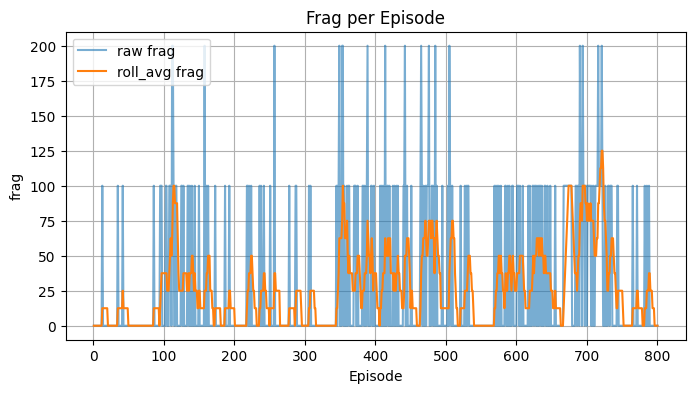

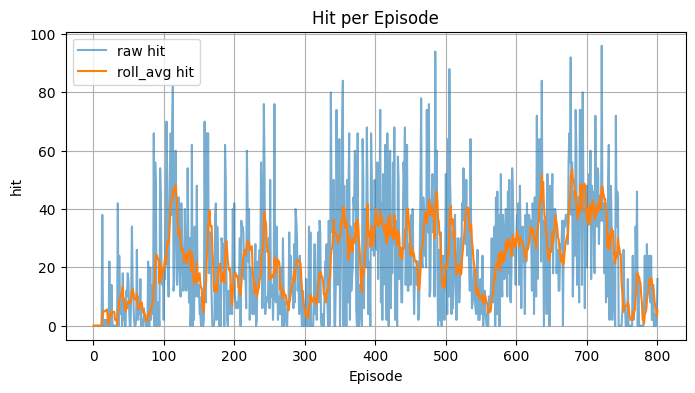

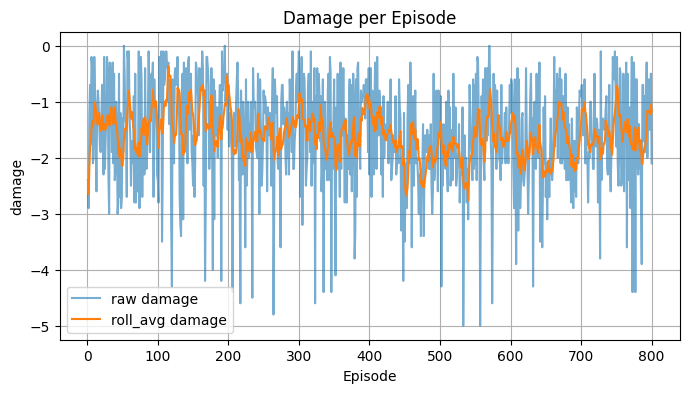

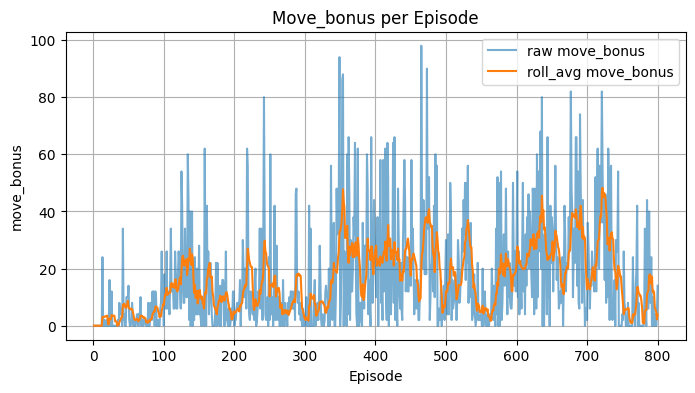

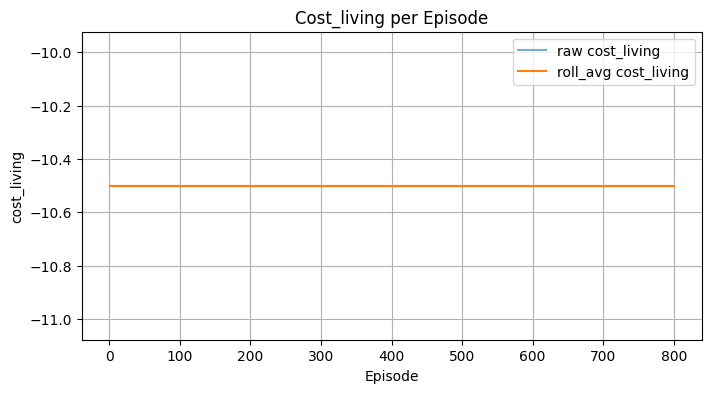

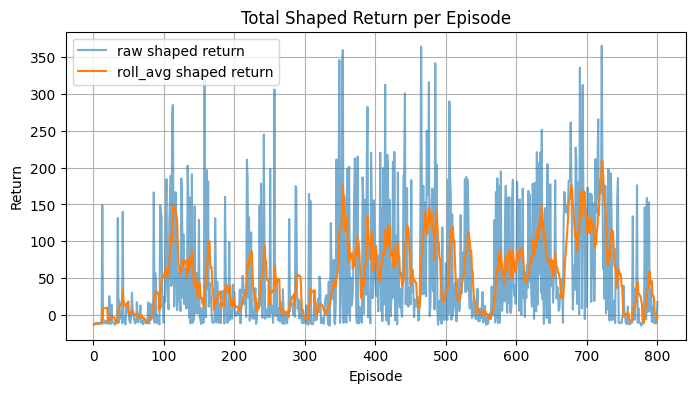

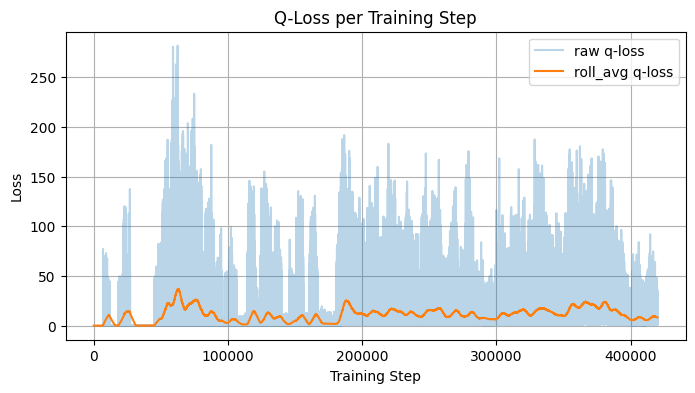

In [ ]:
# reward components
df_metrics = pd.DataFrame(metrics_log)
rolling_metrics = df_metrics.rolling(window=max(1, EPISODES // 100), min_periods=1).mean()
for comp in df_metrics.columns:
    plt.figure(figsize=(8,4))
    plt.plot(df_metrics.index+1, df_metrics[comp], label=f"raw {comp}", alpha=0.6)
    plt.plot(rolling_metrics.index+1, rolling_metrics[comp], label=f"roll_avg {comp}")
    plt.title(f"{comp.capitalize()} per Episode"); plt.xlabel("Episode"); plt.ylabel(comp)
    plt.legend(); plt.grid(True); plt.show()

# total shaped return
rets = pd.Series(episode_returns_log)
rets_roll = rets.rolling(window=max(1, EPISODES // 100), min_periods=1).mean()
plt.figure(figsize=(8,4))
plt.plot(rets.index+1, rets, label="raw shaped return", alpha=0.6)
plt.plot(rets_roll.index+1, rets_roll, label="roll_avg shaped return")
plt.title("Total Shaped Return per Episode"); plt.xlabel("Episode"); plt.ylabel("Return")
plt.legend(); plt.grid(True); plt.show()

# Q-loss
q_loss_s = pd.Series(q_loss_log)
q_loss_roll = q_loss_s.rolling(window=max(1, len(q_loss_log)//100), min_periods=1).mean()
plt.figure(figsize=(8,4))
plt.plot(q_loss_s.index+1, q_loss_s, label="raw q-loss", alpha=0.3)
plt.plot(q_loss_roll.index+1, q_loss_roll, label="roll_avg q-loss")
plt.title("Q-Loss per Training Step"); plt.xlabel("Training Step"); plt.ylabel("Loss")
plt.legend(); plt.grid(True); plt.show()